In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random as rn
import os
from sklearn.model_selection import cross_val_score,StratifiedKFold
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Input, Dropout
from tensorflow.keras.layers import concatenate, BatchNormalization, GlobalAveragePooling1D
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt

## Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
## LIST CHANNELS
list_chanel=['T_fx','T_fy','T_fz','I_fx','I_fy','I_fz','M_fx','M_fy','M_fz','R_fx','R_fy','R_fz','L_fx','L_fy','L_fz','ACC_x','ACC_y','ACC_z']
list_chanel_resultant=['T_resultant','I_resultant','M_resultant','R_resultant','L_resultant']
list_chanel_contribute=['T_contribute','I_contribute','M_contribute','R_contribute','L_contribute']
list_chanel_z=['T_fz','I_fz','M_fz','R_fz','L_fz']
list_feature=['mean','std','meadian','range','length']
list_segment_drink=['pre_drink','rotate_drink', 'hori_drink','rotb_drink','clack_drink']
list_segment_grasp=['pre_grasp','lift_grasp','hold_grasp','lower_grasp','click_grasp']
list_segment=list_segment_drink+list_segment_grasp

In [ ]:
##LAOMO
def customModel(fmn):
    input_channels = Input(shape=[20000,5])
    
    conv = Conv1D(fmn, kernel_size = 15, activation = 'relu', padding = "same")(input_channels)
    conv = Conv1D(fmn, kernel_size = 15, activation = 'relu', padding = "same")(conv)
    conv = MaxPooling1D(pool_size = 25)(conv)
    conv = Conv1D(fmn*2, kernel_size = 7, activation = 'relu', padding = "same")(conv)
    conv = Conv1D(fmn*2, kernel_size = 7, activation = 'relu', padding = "same")(conv)
    conv = MaxPooling1D(pool_size = 10)(conv)
    conv = Conv1D(fmn*4, kernel_size = 5, activation = 'relu', padding="same")(conv)
    conv = Conv1D(fmn*4, kernel_size = 5, activation = 'relu', padding="same")(conv)
    conv = MaxPooling1D(pool_size = 5)(conv)
    conv = Conv1D(fmn*8, kernel_size = 3, activation = 'relu', padding = "same")(conv)
    conv = Conv1D(fmn*8, kernel_size = 3, activation = 'relu', padding = "same")(conv)
    conv = GlobalAveragePooling1D()(conv)
    conv = Flatten()(conv)
    outputs = Dense(2, activation='softmax')(conv)
    model = Model(inputs = input_channels, outputs = outputs)
    optimizer = keras.optimizers.Adam(lr = 0.001)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
fmn = 32
epochs = 50
custom_model = customModel(fmn)
print(custom_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000, 5)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 20000, 32)         2432      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20000, 32)         15392     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 800, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 800, 64)           14400     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 800, 64)           28736     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 80, 64)            0     

In [ ]:
def load_data(fol,ip):
    fn='/home/motionlab/Desktop/Billy/Build model/Channel/Grasp/'+ fol +'/'+ ip + '.csv'
    f=pd.read_csv(fn)
    return f;

HC_T = load_data('HC','T')
HC_I = load_data('HC','I')
HC_M = load_data('HC','M')
HC_R = load_data('HC','R')
HC_L = load_data('HC','L')

TF_T = load_data('TF','T')
TF_I = load_data('TF','I')
TF_M = load_data('TF','M')
TF_R = load_data('TF','R')
TF_L = load_data('TF','L')


X_T = pd.concat([HC_T,TF_T],axis = 0)
X_I = pd.concat([HC_I,TF_I],axis = 0)
X_M = pd.concat([HC_M,TF_M],axis = 0)
X_R = pd.concat([HC_R,TF_R],axis = 0)
X_L = pd.concat([HC_L,TF_L],axis = 0)

X_T = X_T.values
X_I = X_I.values
X_M = X_M.values
X_R = X_R.values
X_L = X_L.values

HC_label = np.zeros(len(HC_T))
TF_label = np.ones(len(TF_T))
Y = np.concatenate((HC_label, TF_label))

del HC_T,HC_I,HC_M,HC_R,HC_L
del TF_T,TF_I,TF_M,TF_R,TF_L

X = np.dstack((X_T,X_I,X_M,X_R,X_L))
del X_T,X_I,X_M,X_R,X_L

X.shape

(234, 20000, 5)

---------------------------------
10 fold cross validation 
Now ==> Start Fold  1
Epoch 1/50
7/7 [==============================] - 16s 2s/step - loss: 0.6829 - accuracy: 0.6238 - val_loss: 0.6594 - val_accuracy: 0.5417
Epoch 2/50
7/7 [==============================] - 0s 25ms/step - loss: 0.5948 - accuracy: 0.6476 - val_loss: 0.5880 - val_accuracy: 0.6250
Epoch 3/50
7/7 [==============================] - 0s 20ms/step - loss: 0.5063 - accuracy: 0.7619 - val_loss: 0.5609 - val_accuracy: 0.6250
Epoch 4/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4691 - accuracy: 0.7190 - val_loss: 0.5704 - val_accuracy: 0.6667
Epoch 5/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4371 - accuracy: 0.7571 - val_loss: 0.5496 - val_accuracy: 0.7083
Epoch 6/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4340 - accuracy: 0.7857 - val_loss: 0.5764 - val_accuracy: 0.6667
Epoch 7/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4151 - accur

7/7 [==============================] - 0s 20ms/step - loss: 0.4382 - accuracy: 0.7762 - val_loss: 0.6603 - val_accuracy: 0.6250
Epoch 9/50
7/7 [==============================] - 0s 30ms/step - loss: 0.4247 - accuracy: 0.8000 - val_loss: 0.6414 - val_accuracy: 0.6667
Epoch 10/50
7/7 [==============================] - 0s 25ms/step - loss: 0.4009 - accuracy: 0.8000 - val_loss: 0.6370 - val_accuracy: 0.7083
Epoch 11/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3563 - accuracy: 0.8143 - val_loss: 0.7516 - val_accuracy: 0.6250
Epoch 12/50
7/7 [==============================] - 0s 25ms/step - loss: 0.3348 - accuracy: 0.8429 - val_loss: 0.7476 - val_accuracy: 0.7083
Epoch 13/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3301 - accuracy: 0.8333 - val_loss: 0.8476 - val_accuracy: 0.7083
Epoch 14/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3938 - accuracy: 0.7762 - val_loss: 0.8204 - val_accuracy: 0.6250
Epoch 15/50
7/7 [================

7/7 [==============================] - 0s 20ms/step - loss: 0.4176 - accuracy: 0.7857 - val_loss: 0.3840 - val_accuracy: 0.8333
Epoch 17/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4129 - accuracy: 0.7667 - val_loss: 0.3962 - val_accuracy: 0.8333
Epoch 18/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3702 - accuracy: 0.8000 - val_loss: 0.3091 - val_accuracy: 0.8333
Epoch 19/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3836 - accuracy: 0.8143 - val_loss: 0.3118 - val_accuracy: 0.8333
Epoch 20/50
7/7 [==============================] - 0s 21ms/step - loss: 0.3383 - accuracy: 0.8286 - val_loss: 0.3569 - val_accuracy: 0.8333
Epoch 21/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3259 - accuracy: 0.8429 - val_loss: 0.3501 - val_accuracy: 0.8333
Epoch 22/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3313 - accuracy: 0.8476 - val_loss: 0.4065 - val_accuracy: 0.8333
Epoch 23/50
7/7 [===============

7/7 [==============================] - 0s 20ms/step - loss: 0.3457 - accuracy: 0.8667 - val_loss: 0.4154 - val_accuracy: 0.7917
Epoch 25/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3577 - accuracy: 0.8095 - val_loss: 0.3203 - val_accuracy: 0.7500
Epoch 26/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4144 - accuracy: 0.7762 - val_loss: 0.4460 - val_accuracy: 0.7917
Epoch 27/50
7/7 [==============================] - 0s 21ms/step - loss: 0.3906 - accuracy: 0.8333 - val_loss: 0.3432 - val_accuracy: 0.7917
Epoch 28/50
7/7 [==============================] - 0s 21ms/step - loss: 0.3925 - accuracy: 0.8238 - val_loss: 0.3644 - val_accuracy: 0.8333
Epoch 29/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3515 - accuracy: 0.8095 - val_loss: 0.2898 - val_accuracy: 0.8333
Epoch 30/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3145 - accuracy: 0.8524 - val_loss: 0.5220 - val_accuracy: 0.7917
Epoch 31/50
7/7 [===============

7/7 [==============================] - 0s 21ms/step - loss: 0.3751 - accuracy: 0.7773 - val_loss: 0.4281 - val_accuracy: 0.7391
Epoch 33/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3454 - accuracy: 0.8104 - val_loss: 0.3764 - val_accuracy: 0.7391
Epoch 34/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3277 - accuracy: 0.8436 - val_loss: 0.3784 - val_accuracy: 0.8261
Epoch 35/50
7/7 [==============================] - 0s 21ms/step - loss: 0.3124 - accuracy: 0.8389 - val_loss: 0.4107 - val_accuracy: 0.8696
Epoch 36/50
7/7 [==============================] - 0s 20ms/step - loss: 0.2948 - accuracy: 0.8768 - val_loss: 0.3227 - val_accuracy: 0.7826
Epoch 37/50
7/7 [==============================] - 0s 20ms/step - loss: 0.2963 - accuracy: 0.8483 - val_loss: 0.2744 - val_accuracy: 0.9130
Epoch 38/50
7/7 [==============================] - 0s 21ms/step - loss: 0.2682 - accuracy: 0.8863 - val_loss: 0.3857 - val_accuracy: 0.7826
Epoch 39/50
7/7 [===============

7/7 [==============================] - 0s 21ms/step - loss: 0.3561 - accuracy: 0.8152 - val_loss: 0.3050 - val_accuracy: 0.8261
Epoch 41/50
7/7 [==============================] - 0s 28ms/step - loss: 0.3246 - accuracy: 0.8341 - val_loss: 0.2975 - val_accuracy: 0.8696
Epoch 42/50
7/7 [==============================] - 0s 21ms/step - loss: 0.2994 - accuracy: 0.8626 - val_loss: 0.3257 - val_accuracy: 0.7826
Epoch 43/50
7/7 [==============================] - 0s 21ms/step - loss: 0.3074 - accuracy: 0.8578 - val_loss: 0.4345 - val_accuracy: 0.6957
Epoch 44/50
7/7 [==============================] - 0s 21ms/step - loss: 0.3569 - accuracy: 0.8199 - val_loss: 0.3224 - val_accuracy: 0.8261
Epoch 45/50
7/7 [==============================] - 0s 22ms/step - loss: 0.6081 - accuracy: 0.8009 - val_loss: 0.3076 - val_accuracy: 0.8696
Epoch 46/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3349 - accuracy: 0.8389 - val_loss: 0.3280 - val_accuracy: 0.8696
Epoch 47/50
7/7 [===============

7/7 [==============================] - 0s 21ms/step - loss: 0.0420 - accuracy: 0.9810 - val_loss: 1.0106 - val_accuracy: 0.8261
Epoch 49/50
7/7 [==============================] - 0s 20ms/step - loss: 0.1364 - accuracy: 0.9573 - val_loss: 1.1229 - val_accuracy: 0.7826
Epoch 50/50
7/7 [==============================] - 0s 19ms/step - loss: 1.2113 - accuracy: 0.8531 - val_loss: 1.8753 - val_accuracy: 0.7391
The accuracy in this fold: 73.913043
---------------------------------
Now ==> Start Fold  8
Epoch 1/50
7/7 [==============================] - 0s 34ms/step - loss: 0.6626 - accuracy: 0.5592 - val_loss: 0.5075 - val_accuracy: 0.6957
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 0.5535 - accuracy: 0.7251 - val_loss: 0.4694 - val_accuracy: 0.7391
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 0.5333 - accuracy: 0.6919 - val_loss: 0.4026 - val_accuracy: 0.8261
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 0.4994 - ac

7/7 [==============================] - 0s 20ms/step - loss: 0.4853 - accuracy: 0.7156 - val_loss: 0.4250 - val_accuracy: 0.8696
Epoch 6/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4868 - accuracy: 0.7583 - val_loss: 0.3783 - val_accuracy: 0.8696
Epoch 7/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4730 - accuracy: 0.7630 - val_loss: 0.3996 - val_accuracy: 0.8696
Epoch 8/50
7/7 [==============================] - 0s 21ms/step - loss: 0.4731 - accuracy: 0.7299 - val_loss: 0.4396 - val_accuracy: 0.7391
Epoch 9/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4625 - accuracy: 0.7441 - val_loss: 0.4837 - val_accuracy: 0.6957
Epoch 10/50
7/7 [==============================] - 0s 21ms/step - loss: 0.4556 - accuracy: 0.7773 - val_loss: 0.3880 - val_accuracy: 0.8261
Epoch 11/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4439 - accuracy: 0.7678 - val_loss: 0.4011 - val_accuracy: 0.8261
Epoch 12/50
7/7 [===================

7/7 [==============================] - 0s 22ms/step - loss: 0.4156 - accuracy: 0.7915 - val_loss: 0.4047 - val_accuracy: 0.7826
Epoch 14/50
7/7 [==============================] - 0s 23ms/step - loss: 0.4141 - accuracy: 0.8057 - val_loss: 0.3760 - val_accuracy: 0.8261
Epoch 15/50
7/7 [==============================] - 0s 22ms/step - loss: 0.3984 - accuracy: 0.7773 - val_loss: 0.4399 - val_accuracy: 0.8261
Epoch 16/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3970 - accuracy: 0.8057 - val_loss: 0.3395 - val_accuracy: 0.8261
Epoch 17/50
7/7 [==============================] - 0s 21ms/step - loss: 0.3720 - accuracy: 0.8199 - val_loss: 0.4025 - val_accuracy: 0.7826
Epoch 18/50
7/7 [==============================] - 0s 23ms/step - loss: 0.3995 - accuracy: 0.8152 - val_loss: 0.4190 - val_accuracy: 0.7391
Epoch 19/50
7/7 [==============================] - 0s 21ms/step - loss: 0.4118 - accuracy: 0.7962 - val_loss: 0.4770 - val_accuracy: 0.7826
Epoch 20/50
7/7 [===============

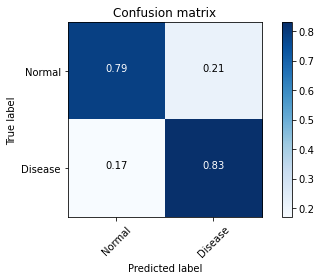

 Total Accuracy (average +- std):  80.83333333333334 +- 9.130434782608695


In [ ]:

cvscores = []
print('---------------------------------')
print('10 fold cross validation ')
k_fold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 17)
conf_mat_all = np.expand_dims(np.zeros(shape = (2, 2)), axis = 2)
i = 1
for train, validate in k_fold.split(X,Y) :
    print('Now ==> Start Fold ',i)
    x_train,y_train = X[train],Y[train]
    x_validate,y_validate = X[validate],Y[validate]
    y_train = keras.utils.to_categorical(y_train)
    y_validate = keras.utils.to_categorical(y_validate)
    model = customModel(fmn)
    history = model.fit(x_train,y_train,epochs=epochs,verbose=1,validation_data = (x_validate, y_validate))
    pred = model.predict(x_validate)
    # correct below
    pred = np.argmax(pred, axis=-1)
    y_validate_ind = np.argmax(y_validate, axis=-1)
    scores = accuracy_score(y_validate_ind,pred)*100
    # correct above
    print("The accuracy in this fold: %f"%scores)
    print("---------------------------------")
    cvscores.append(scores)
    conf_mat = np.expand_dims(confusion_matrix(y_validate_ind, pred), axis = 2)
    conf_mat_all = np.concatenate([conf_mat_all, conf_mat], axis = 2)    
    i += 1
conf_mat_sum = np.sum(conf_mat_all, axis = 2)
plot_confusion_matrix(conf_mat_sum, classes = ['Normal','Disease'], 
                      cmap = plt.cm.Blues, normalize = True)
plt.show()
print(" Total Accuracy (average +- std): ", np.mean(cvscores),'+-',np.std(cvscores))
print("=======================================")
mean=np.mean(cvscores)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


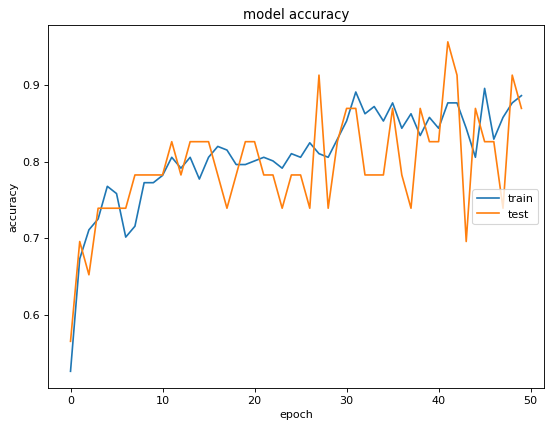

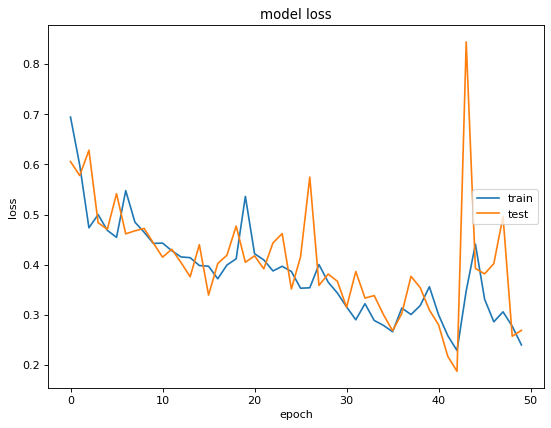

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
from matplotlib.pyplot import figure
figure(num = None, figsize=(8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()
#plt.savefig('acc.pdf')

figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()
# plt.savefig('loss.pdf')

In [ ]:

HC_T=load_data('HC','T_test')
HC_I=load_data('HC','I_test')
HC_M=load_data('HC','M_test')
HC_R=load_data('HC','R_test')
HC_L=load_data('HC','L_test')
# HC_x=load_data('HC','x_test')
# HC_y=load_data('HC','y_test')
# HC_z=load_data('HC','z_test')

TF_T=load_data('TF','T_test')
TF_I=load_data('TF','I_test')
TF_M=load_data('TF','M_test')
TF_R=load_data('TF','R_test')
TF_L=load_data('TF','L_test')
# TF_x=load_data('TF','x_test')
# TF_y=load_data('TF','y_test')
# TF_z=load_data('TF','z_test')

In [ ]:
X_T = pd.concat([HC_T,TF_T], axis = 0)
X_I = pd.concat([HC_I,TF_I], axis = 0)
X_M = pd.concat([HC_M,TF_M], axis = 0)
X_R = pd.concat([HC_R,TF_R], axis = 0)
X_L = pd.concat([HC_L,TF_L], axis = 0)

X_T = X_T.values
X_I = X_I.values
X_M = X_M.values
X_R = X_R.values
X_L = X_L.values

HC_label = np.zeros(len(HC_T))
TF_label = np.ones(len(TF_T))
Y = np.concatenate((HC_label,TF_label))

del HC_T,HC_I,HC_M,HC_R,HC_L
del TF_T,TF_I,TF_M,TF_R,TF_L

In [ ]:
X=np.dstack((X_T,X_I,X_M,X_R,X_L))
del X_T,X_I,X_M,X_R,X_L

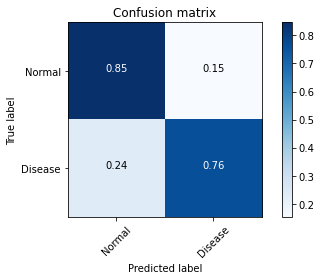

 Total Accuracy (average +- std):  78.72340425531915 +- 0.0


In [ ]:
pred=model.predict(X)
pred = np.argmax(pred, axis = -1)
scores = accuracy_score(Y, pred)*100
conf_mat = np.expand_dims(confusion_matrix(Y, pred), axis = 2)
conf_mat_sum = np.sum(conf_mat, axis = 2)
plot_confusion_matrix(conf_mat_sum, classes = ['Normal','Disease'], 
                      cmap = plt.cm.Blues,normalize = True)
plt.show()
print(" Total Accuracy (average +- std): ", np.mean(scores),'+-', np.std(scores))
print("=======================================")